In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)

data = pd.read_csv('trainset.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [2]:
train = data.drop(['NAME','NAME2', 'Carrier_Code(IATA)', 'Cancelled', 'Diverted', 'Estimated_Departure_Time', 'Estimated_Arrival_Time'], axis=1)

In [8]:
train['Estimated_Departure_Time_HH:MM'].iloc[0]

'07:40'

In [9]:
train['Delay'].value_counts()

Not_Delayed    207484
Delayed         44477
Name: Delay, dtype: int64

<AxesSubplot: xlabel='Delay', ylabel='Estimated_Time'>

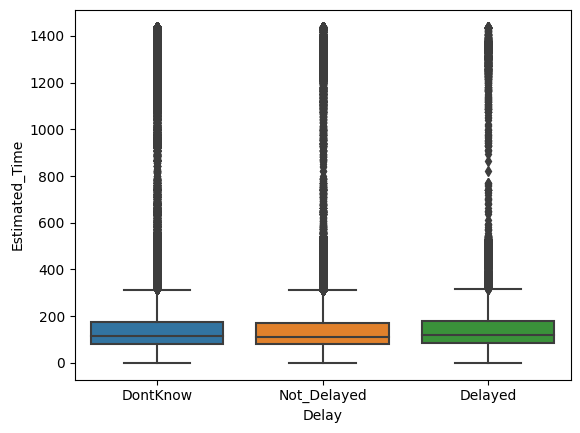

In [42]:
sns.boxplot(x='Delay', y='Estimated_Time', data=train)

<AxesSubplot: xlabel='Delay', ylabel='Distance'>

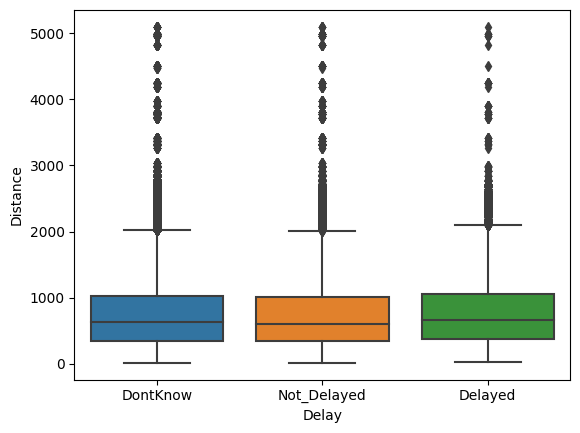

In [44]:
sns.boxplot(x='Delay', y='Distance', data=train)


In [51]:
plot_data = train.groupby('Airline')[['Delay']].value_counts().reset_index().rename(columns={0:'count'})

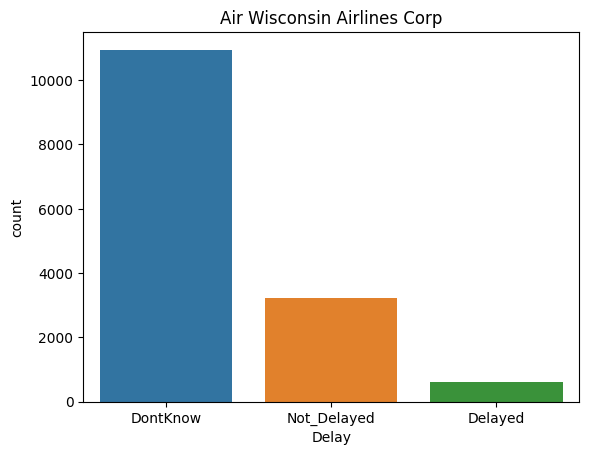

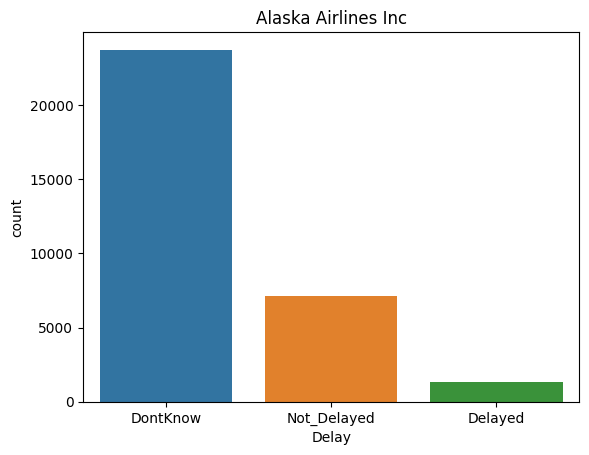

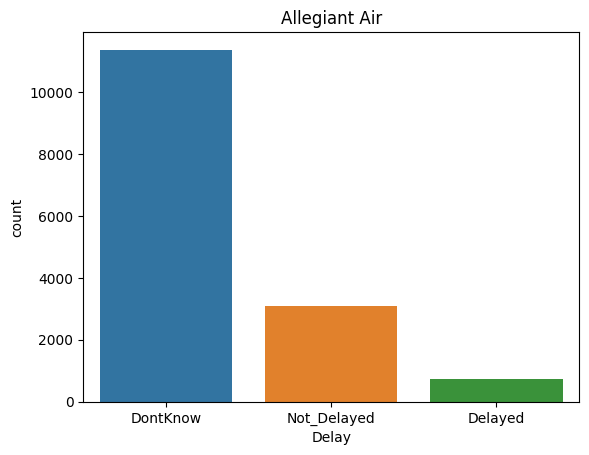

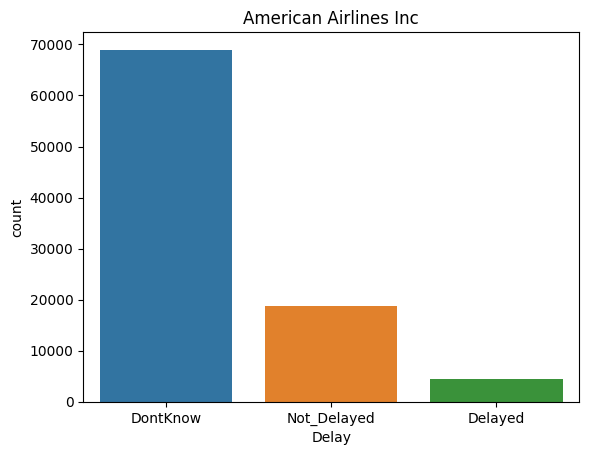

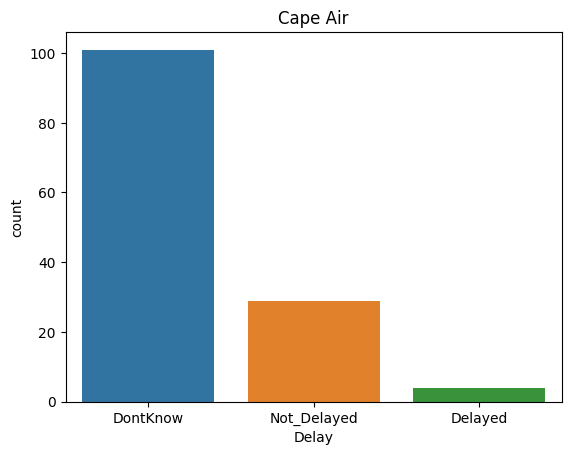

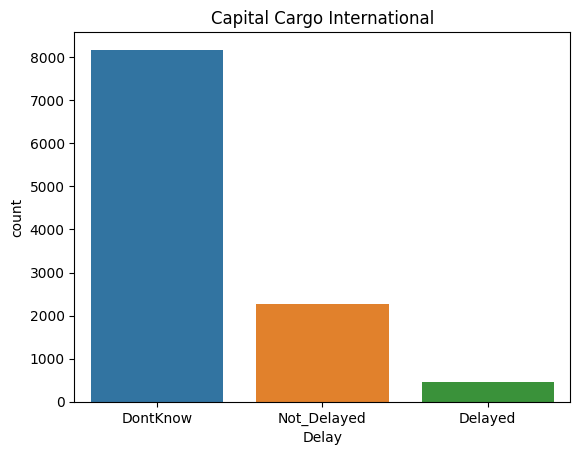

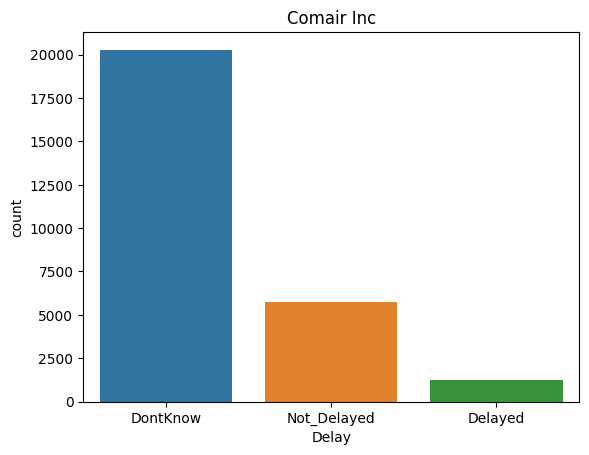

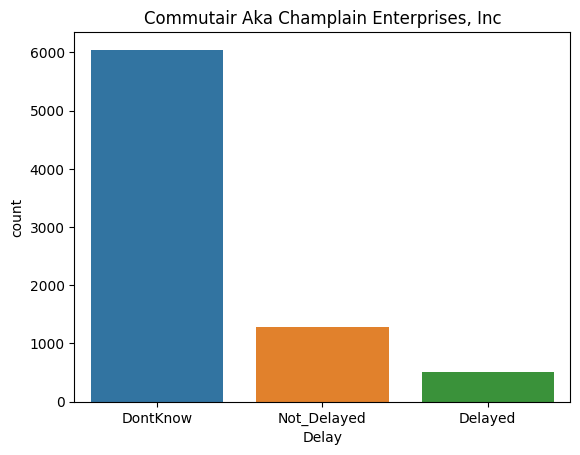

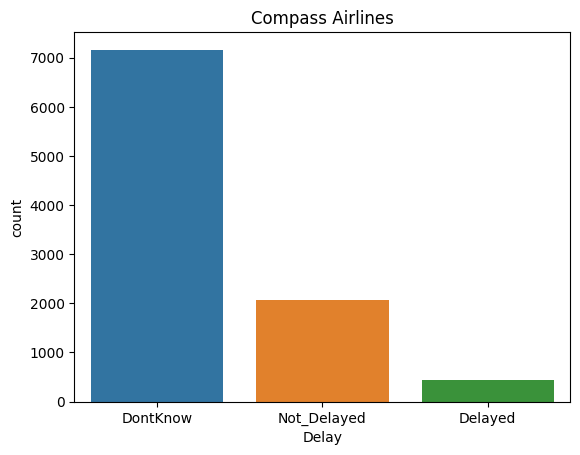

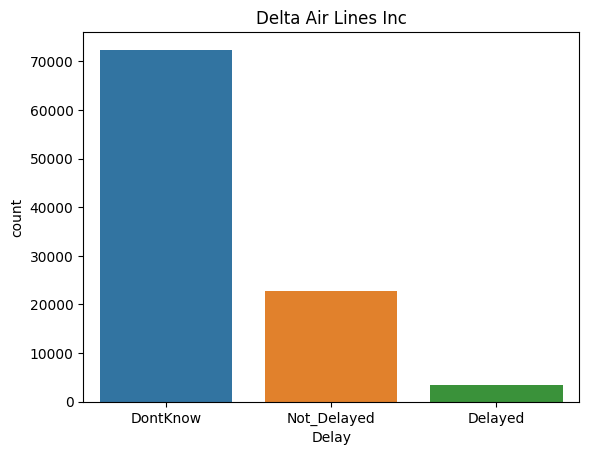

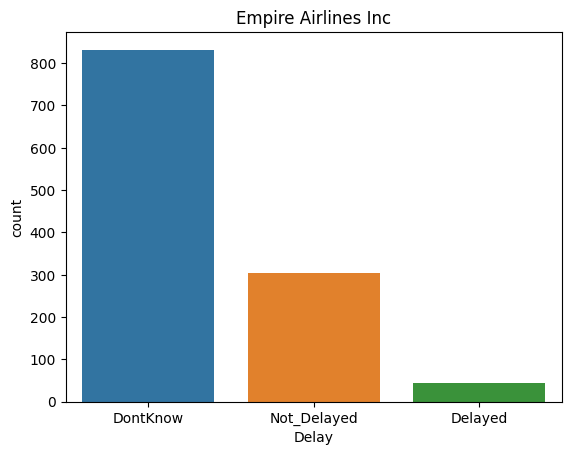

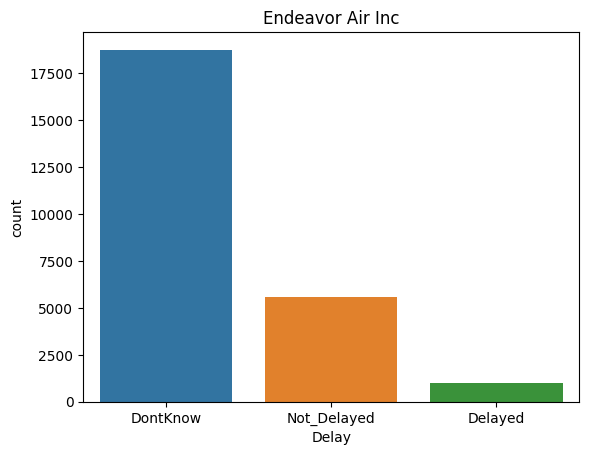

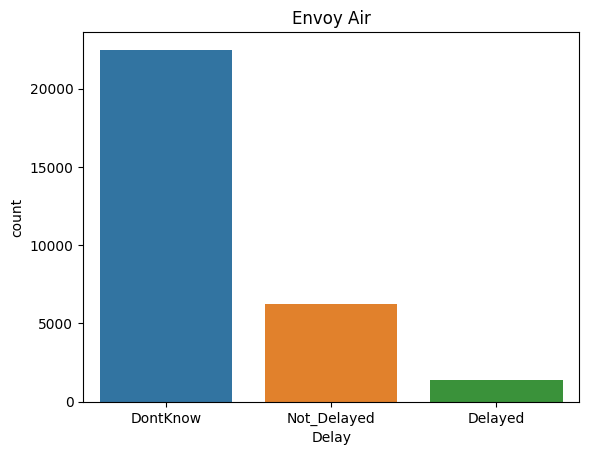

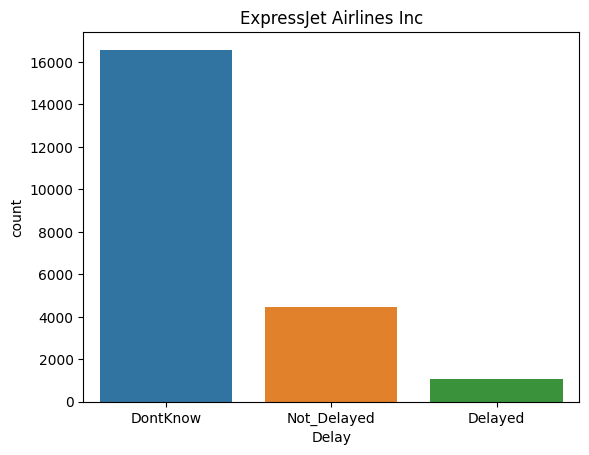

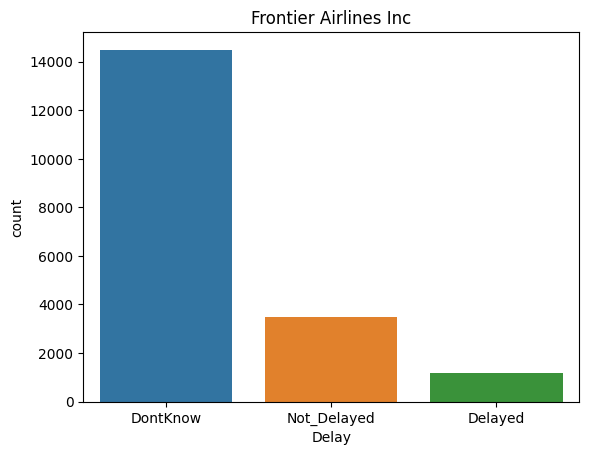

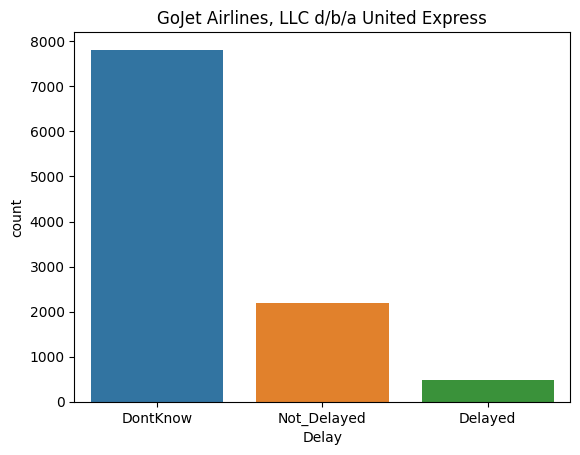

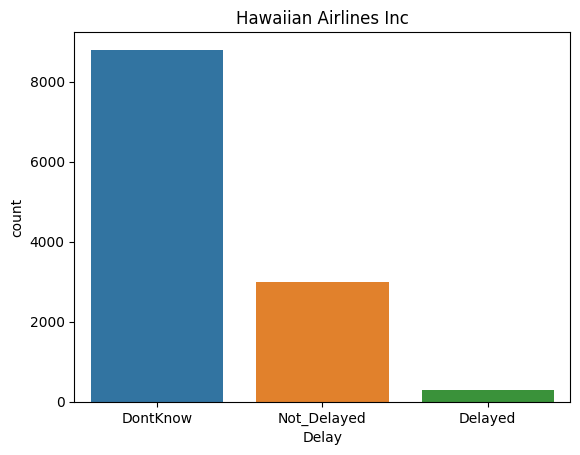

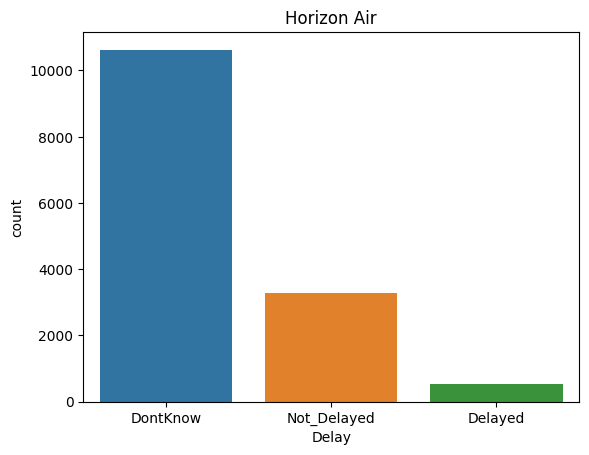

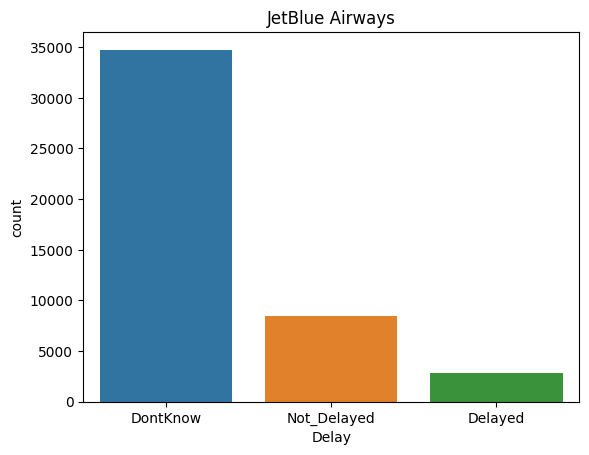

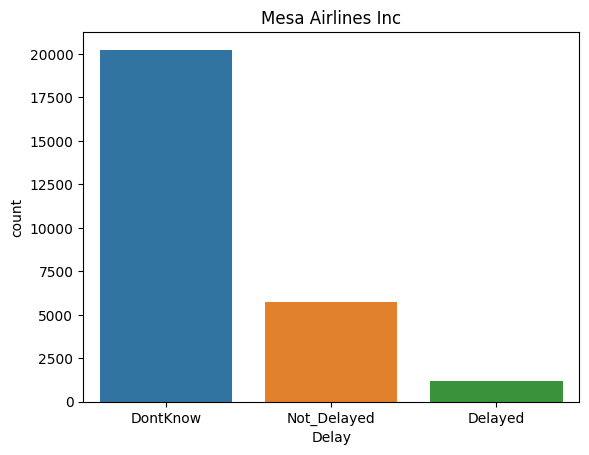

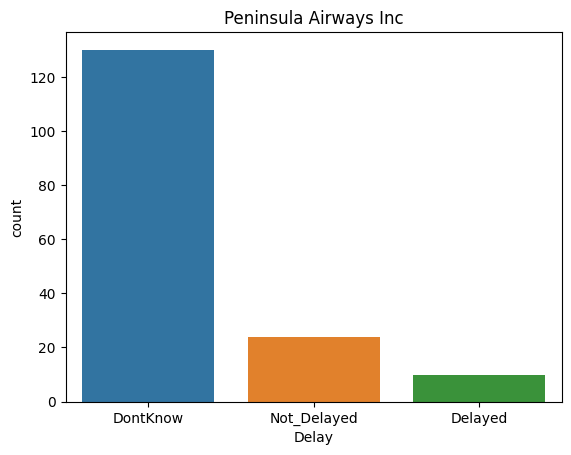

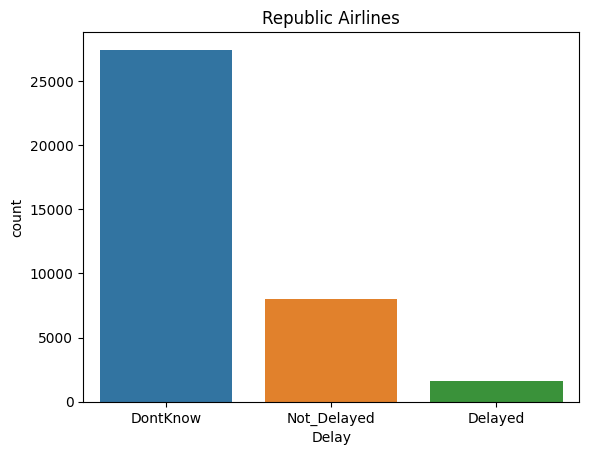

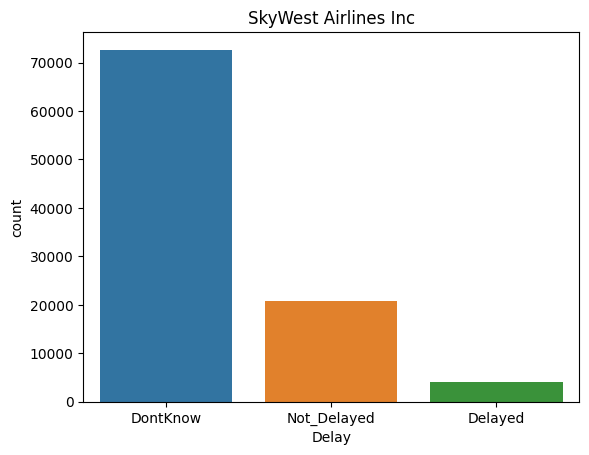

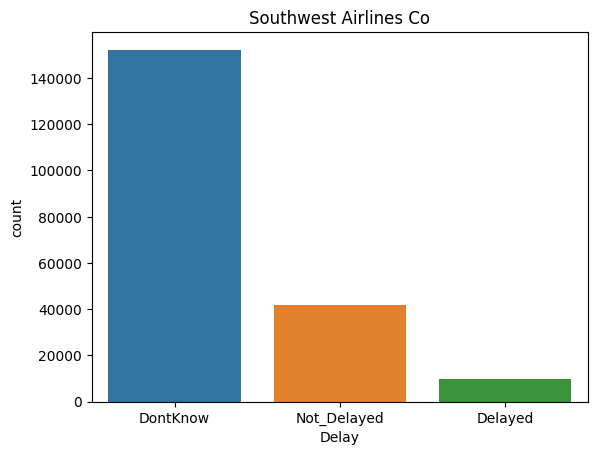

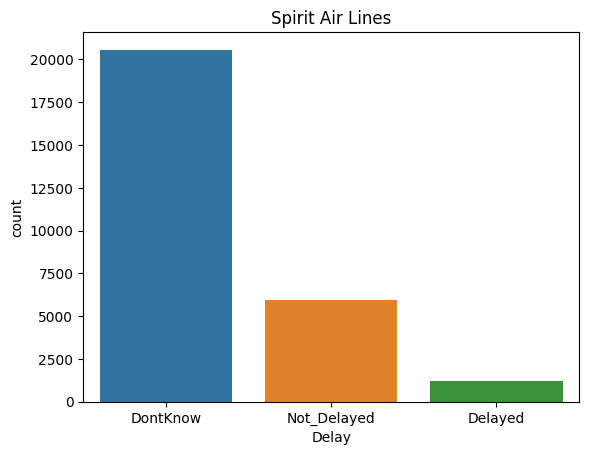

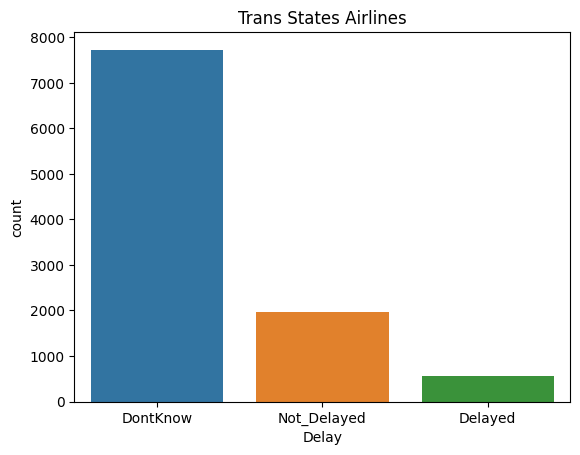

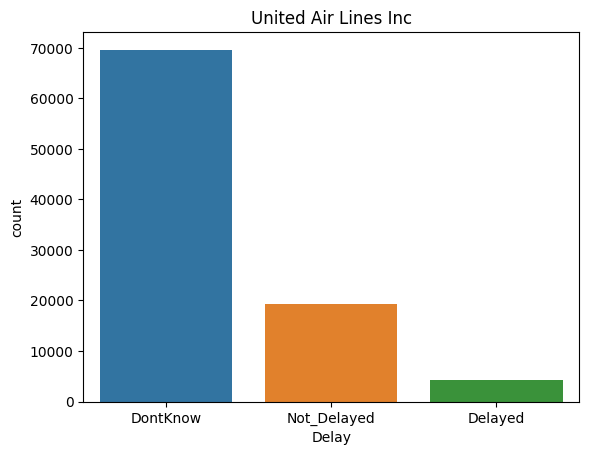

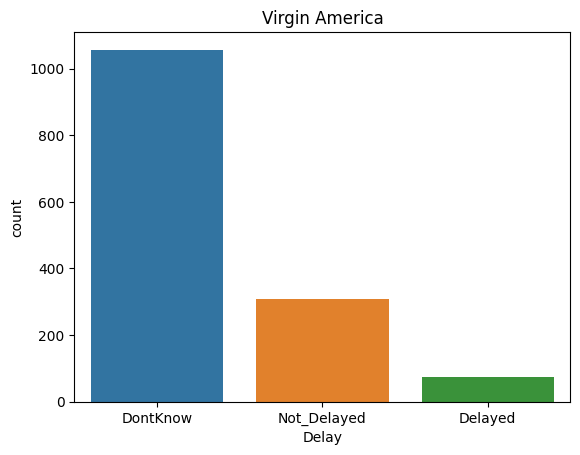

In [60]:
for airline in plot_data.Airline.unique():
    plot = plot_data[plot_data['Airline'] == airline]
    sns.barplot(x='Delay', y='count', data=plot)
    plt.title(airline)
    plt.show()

In [56]:
plot

,ID,Month,Day_of_Month,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_ID(DOT),Tail_Number,Delay,Estimated_Departure_Time_HH:MM,Estimated_Arrival_Time_HH:MM,Estimated_Time,Dep_time_gb,Arr_time_gb,route_gb
17,TRAIN_000018,8,11,CRW,11146,West Virginia,ORD,13930,Illinois,416.0,Air Wisconsin Airlines Corp,20046.0,N440AW,DontKnow,12:15,12:58,43.0,1200-1259,1200-1259,short_route
21,TRAIN_000022,3,6,BUF,10792,New York,IAD,12264,Virginia,283.0,Air Wisconsin Airlines Corp,20046.0,N421ZW,DontKnow,10:30,11:50,80.0,1000-1059,1100-1159,short_route
61,TRAIN_000062,10,18,IAD,12264,Virginia,ROC,14576,New York,288.0,Air Wisconsin Airlines Corp,20046.0,N465AW,DontKnow,13:00,14:19,79.0,1300-1359,1400-1459,short_route
67,TRAIN_000068,6,17,RST,14633,Minnesota,ORD,13930,Illinois,268.0,Air Wisconsin Airlines Corp,20046.0,N429AW,Not_Delayed,09:36,11:05,89.0,0900-0959,1100-1159,short_route
82,TRAIN_000083,5,4,ORD,13930,Illinois,CMH,11066,Ohio,296.0,Air Wisconsin Airlines Corp,20046.0,N441ZW,DontKnow,09:40,12:00,140.0,0900-0959,1200-1259,short_route
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988119,TRAIN_999839,9,22,SYR,15096,New York,ORD,13930,Illinois,607.0,Air Wisconsin Airlines Corp,20046.0,N447AW,Not_Delayed,16:00,17:10,70.0,1600-1659,1700-1759,short_route
988131,TRAIN_999851,10,27,LAN,12884,Michigan,ORD,13930,Illinois,179.0,Air Wisconsin Airlines Corp,20046.0,N467AW,Not_Delayed,10:25,10:45,20.0,1000-1059,1000-1059,short_route
988142,TRAIN_999862,2,11,CAE,10868,South Carolina,IAD,12264,Virginia,401.0,Air Wisconsin Airlines Corp,20046.0,N424AW,Not_Delayed,09:45,11:15,90.0,0900-0959,1100-1159,short_route
988149,TRAIN_999869,9,15,AZO,10469,Michigan,ORD,13930,Illinois,122.0,Air Wisconsin Airlines Corp,20046.0,N469AW,DontKnow,14:44,14:49,5.0,1400-1459,1400-1459,short_route


# Feature Engineering

In [2]:
train['edt_h'] = train['Estimated_Departure_Time_HH:MM'].apply(lambda x:int(x.split(':')[0]))
train['edt_m'] = train['Estimated_Departure_Time_HH:MM'].apply(lambda x:int(x.split(':')[1]))
train['eat_h'] = train['Estimated_Arrival_Time_HH:MM'].apply(lambda x:int(x.split(':')[0]))
train['eat_m'] = train['Estimated_Arrival_Time_HH:MM'].apply(lambda x:int(x.split(':')[1]))

train = train.drop(['Estimated_Departure_Time_HH:MM', 'Estimated_Arrival_Time_HH:MM'], axis=1)

NameError: name 'train' is not defined

# DBSCAN

In [4]:
ctrain = train[['Month', 'Day_of_Month', 'Distance', 'Estimated_Time', 'edt_h', 'edt_m', 'eat_h', 'eat_m']]
ctrain = train[[ 'Distance', 'Estimated_Time']]

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(ctrain), columns = ctrain.columns)

In [6]:
from sklearn.cluster import DBSCAN

# epsilon, 최소 샘플 개수 설정
model = DBSCAN(eps=0.5, min_samples=2)

# 군집화 모델 학습 및 클러스터 예측 결과 반환
model.fit(df_scale)
df_scale['cluster'] = model.fit_predict(df_scale)

MemoryError: 

In [78]:
df_scale.columns

Index(['Month', 'Day_of_Month', 'Distance', 'Estimated_Time', 'edt_h', 'edt_m',
       'eat_h', 'eat_m', 'cluster'],
      dtype='object')

In [80]:
df_scale['cluster'].value_counts()

 0       907135
-1        26101
 5        11875
 1         9721
 6         2625
          ...  
 4369         2
 4367         2
 4363         2
 4360         2
 8791         2
Name: cluster, Length: 8793, dtype: int64

# Self Training Classifier

# SNORKEL

In [21]:
train['Delay'] = train['Delay'].fillna('DontKnow')

In [37]:
from snorkel.labeling import labeling_function
import re
Delayed = 1
Not_Delayed = 0
DontKnow = 2
@labeling_function()
def route_check(x):
    return Not_Delayed if 'long_route' in x['route_gb'] else DontKnow


In [38]:
from snorkel.labeling import PandasLFApplier

lfs = [route_check]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train)

100%|██████████| 988278/988278 [00:06<00:00, 143921.94it/s]


In [39]:
coverage_check = (L_train != DontKnow).mean(axis=0)
print(f"check coverage: {coverage_check * 100}%")


check coverage: [0.15855862]%


In [40]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
route_check,0,"[0, 2]",1.0,0.0,0.0
